## Comparison of different Optimizer choices with sin function
Available Optimizers: ["adaptive_gradient_descent", "adaptive_newton", "bfgs", "cmaes", "differential_evolution", "gradient_descent", "nlcg", "nelder_mead", "newton", "rprop"]


## Imports and dataset

2023-03-09 07:47:29.192133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 07:47:31.202357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-03-09 07:47:31.202542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-03-09 07:47:31.202553: W tensorflow/compiler/tf2tensorrt/utils/py_utils

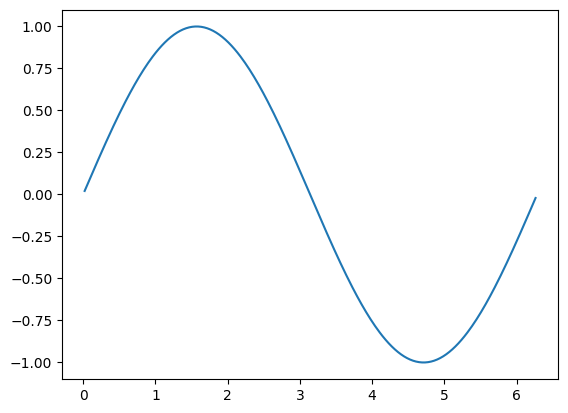

In [1]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

import timeit

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

X = []
Y = []

num_samples = 300

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)

BUDGET = 2
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

ITER = 4

BUDGETS = [i*10 for i in range(1, ITER+1)]

## Hyperparameterspace & Model & Function

In [2]:
hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    'epochs': ["interval-int", 1, 400]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste


##################### Function for sparse grid search #####################

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        epochs = int(from_standard(1, 400, x[1]))
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(10, input_shape=(1,), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        # scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

        # return -scores.mean()

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
        


## Sparse grid search (Comparison of the optimizers)

In [3]:
available_optimizers = ["adaptive_gradient_descent", "adaptive_newton", "bfgs", "cmaes", "differential_evolution", "gradient_descent", "nlcg", "nelder_mead", "newton", "rprop"]

BUDGETS = [i*10 for i in range(1, ITER+1)]

TIMES = [[] for _ in range(len(available_optimizers))]
RESULTS = [[] for _ in range(len(available_optimizers))]
RESULTS_OPTIMIZED = [[] for _ in range(len(available_optimizers))]

for j in range(len(available_optimizers)):
    print("Current optimizer:", j, available_optimizers[j])

    sparse_params=[3, 0.95, available_optimizers[j]]

    BUDGET = 10
    for i in range(1, ITER+1):
        BUDGET = 10*i

        f = ExampleFunction()

        optimization = HPO.Optimization(dataset, f, hyperparameterspace, type="sparse", budget=BUDGET, verbosity=VERBOSE, sparse_params=sparse_params)

        starttime = timeit.default_timer()
        result = optimization.fit()
        endtime = timeit.default_timer()

        print(result)

        TESTING = True
        RESULTS[j].append(f.eval(result[0]))
        RESULTS_OPTIMIZED[j].append(f.eval(result[1]))
        TESTING = False

        TIMES[j].append(endtime - starttime)


Current optimizer: 0 adaptive_gradient_descent
Adaptive grid generation (Ritter-Novak)...


2023-03-09 07:47:34.241738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-09 07:47:34.241848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maxi-XPS-15-9560): /proc/driver/nvidia/version does not exist
2023-03-09 07:47:34.245741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done in 62080ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.
([0.75, 0.5], [0.8095309843217484, 0.6258774940395527])
Adaptive grid generation (Ritter-Novak)...
Done in 60471ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.
([0.75, 0.75], [0.7383649883279119, 0.7371981767709226])
Adaptive grid generation (Ritter-Novak)...
Done in 100263ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.
([0.75, 0.625], [0.871694185371345, 0.5643182382212198])
Adaptive grid generation (Ritter-Novak)...
Done in 133707ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.
([0.75, 0.625], [0.7832238745068322, 0.5643627056275548])
Current optimizer: 1 adaptive_newton
Adaptive grid generation (Ritter-Novak)...
Done in 60799ms.
Solving linear system (autom

## Plotting

### Results (not optimized)

[[0.029984000002534886, 0.0005103837249679518, 8.84024153697353e-05, 0.00015254533514859892], [0.00037493339808352587, 0.00018983390713021945, 0.0011679603260208392, 0.0003010938791484267], [5.218756364026948e-05, 0.0001857859832989269, 0.00020093270619938897, 0.003199951315923463], [4.479704894033524e-05, 0.00048517296246950077, 0.0017719843590667712, 0.00015648655181864206], [0.03649481583114828, 0.0003128340892619534, 0.00013093491213191736, 0.0009289876836289771], [0.0001522088698974996, 0.001605170248433847, 0.000197014898569751, 6.866370992859328e-05], [0.005725164722499981, 0.0011465107083130236, 0.0007005237076115179, 0.0005194537529702022], [0.03790324928792115, 0.008128458792357986, 0.00861517183499641, 0.0001817323644991387], [8.763720178160775e-05, 0.0006267142049952425, 0.00019550537345630798, 0.000600682485231239], [9.303293905694177e-05, 0.0007984786466349018, 0.01997878666465687, 0.000320508873030001]]


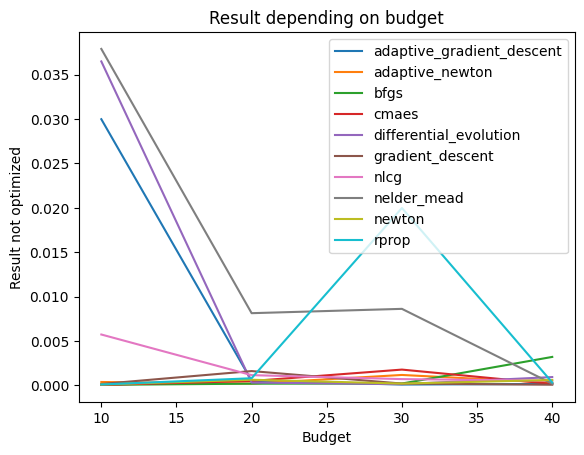

In [4]:
print(RESULTS)

for i in range(len(available_optimizers)):
    plt.plot(BUDGETS, RESULTS[i], label = available_optimizers[i])

plt.xlabel('Budget')
plt.ylabel('Result not optimized')

plt.title('Result depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

### Results (optimized)

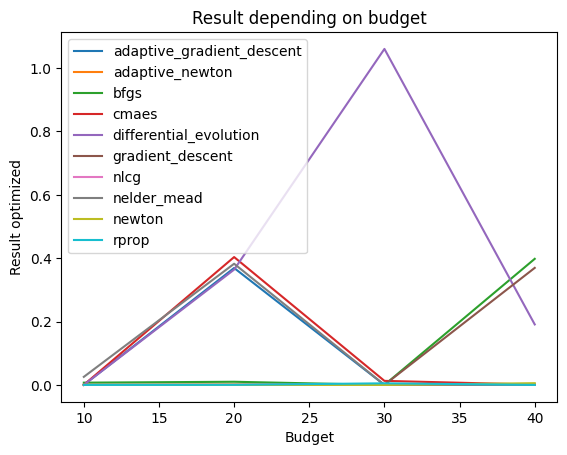

In [5]:
for i in range(len(available_optimizers)):
    plt.plot(BUDGETS, RESULTS_OPTIMIZED[i], label = available_optimizers[i])

plt.xlabel('Budget')
plt.ylabel('Result optimized')

plt.title('Result depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

### Times

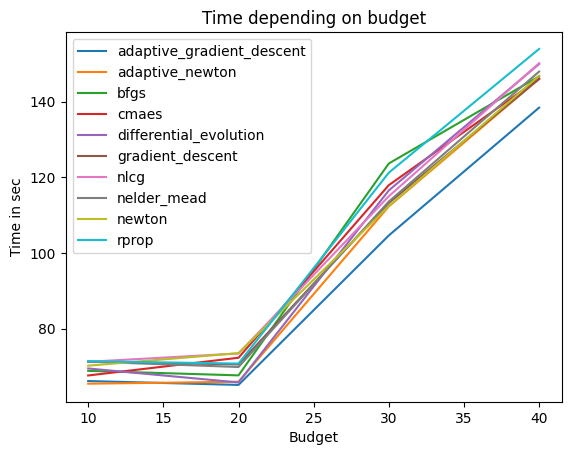

In [6]:
for i in range(len(available_optimizers)):
    plt.plot(BUDGETS, TIMES[i], label = available_optimizers[i])

plt.xlabel('Budget')
plt.ylabel('Time in sec')

plt.title('Time depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()